# CNN
CNNs are often for spatial data like images, but using them here to capture patterns across different periods.

In [1]:
from data_loader import load_names_from_web, holdout_split

In [2]:
# pip install keras-tuner

In [29]:
import numpy as np
from numpy import array
from numpy import hstack

import pandas as pd

from keras.models import Sequential
# from keras.layers import LSTM, RepeatVector, TimeDistributed
from keras.layers import Dense, Flatten, Conv1D, Input, MaxPooling1D
from keras.layers import BatchNormalization

from keras.optimizers import Adam
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
# from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler





## load and format data

In [4]:
dfraw = load_names_from_web(category="national", hide_pre_1937=True, use_existing_files=True)
dfraw.sample(5)

,state,year,name,M/F,count
885177,US,1949,Loyola,F,5
984152,US,1988,Shawanna,F,42
1177875,US,1979,Ron,M,282
280003,US,2002,Denley,M,6
673871,US,1973,Keldrick,M,9


In [5]:
df1 = dfraw.copy()
df1['name_g'] = df1['name'] + '_' + df1['M/F']
df1.drop(columns=['state', 'name', 'M/F'], inplace=True)
df1.head()

,year,count,name_g
0,2000,25957,Emily_F
1,2000,23085,Hannah_F
2,2000,19968,Madison_F
3,2000,17998,Ashley_F
4,2000,17712,Sarah_F


In [6]:
# for now, lets just look at names that have been used continuously throughout the years.
# for later iterations, can replace this cell with another cell creating df2
unique_years = df1['year'].nunique()
complete_records = df1.groupby('name_g').filter(lambda x: x['year'].nunique() == unique_years)
df2 = complete_records.reset_index(drop=True)
print(df2.shape, 'names: ', df2['name_g'].nunique())
df2.head()

(202702, 3) names:  2357


,year,count,name_g
0,2000,25957,Emily_F
1,2000,23085,Hannah_F
2,2000,17712,Sarah_F
3,2000,17265,Samantha_F
4,2000,15711,Jessica_F


In [7]:
# reformat the dataframe with a column for each name
df3 = df2.pivot(index='year', columns='name_g', values='count')
print(df3.shape)
df3.head()

(86, 2357)


name_g,Aaron_M,Abbie_F,Abby_F,Abe_M,Abel_M,Abelardo_M,Abigail_F,Abner_M,Abraham_M,Abram_M,...,Zack_M,Zana_F,Zane_M,Zeb_M,Zelda_F,Zena_F,Zenobia_F,Zina_F,Zoe_F,Zulema_F
year,,,,,,,,,,,,,,,,,,,,,
1937,465,52,25,63,91,25,45,39,217,31,...,32,15,49,17,147,16,33,12,72,8
1938,477,56,21,55,87,28,50,49,212,37,...,31,15,62,15,145,16,36,11,65,17
1939,471,70,24,56,95,31,53,34,197,31,...,33,8,61,12,127,13,47,15,55,19
1940,514,57,37,54,101,33,48,34,219,23,...,18,18,68,16,128,19,35,13,54,18
1941,562,50,32,66,121,17,40,38,194,29,...,30,10,52,11,106,21,25,14,60,21


## normalize
so the NN can converge more quickly

In [8]:
# this creates a scaler for each name
scalers = {name: StandardScaler() for name in df3.columns}

In [9]:
df4 = df3.copy()
for name in df4.columns:
    df4[name] = scalers[name].fit_transform(df4[name].values.reshape(-1, 1))

## separate the train / validation / test data and sequences 
The aproach here is that the names are independent -- they do not affect each other. However, they might have similar shapes/patterns at different times. So to make predictions, the model should learn from all of the time series. Sequences from multiple names are combined into a single training set.

I will do it this way:
1. separate the names that will be used for the test set.
2. If I am using m names to predict n years into the future, the **validation y will consist of the last n years for each name.** The validation X data will consist of the m previous years for each name.
3. **The train X and y data will not overlap with any of the last n years.** 
4. (I believe I can use test names for training as long as the training X and y do not touch any of the last n years, but I will **not** do that for now)

An assumption is being made here that typical shapes have not changed in recent years.

In [10]:
input_length = 15 # was 10
pred_length = 2
test_size = 0.2

xy_seq_length = input_length + pred_length

In [11]:
# separate the names that will be used for final test. I also only want the last years for test
test_df = df4.sample(frac = test_size, random_state=42, axis=1).tail(xy_seq_length)
train_val = df4.drop(test_df.columns, axis=1)
print(df4.shape, train_val.shape, test_df.shape)

(86, 2357) (86, 1886) (17, 471)


In [12]:
# split train and validation
val_df = train_val.tail(xy_seq_length)
train_df1 = train_val.head(len(train_val)-xy_seq_length)
print(train_df1.shape, val_df.shape)

(69, 1886) (17, 1886)


In [13]:
# val and test are already formatted as subsequences, 
#    each column is a time series subsequence m + n long

# now we will format train in the same way
def array_to_sequences(train_array, input_length, pred_length):
    '''
    input: an array (where each column is a time series)
    creates a new array where each column is a time-series sub sequence    
    '''
    subsequence_length = input_length + pred_length
    n_subsequences = train_array.shape[0] - subsequence_length + 1
    
    subsequences = []
    for col in range(train_array.shape[1]):
        for start_row in range(n_subsequences):
            subsequence = train_array[start_row:start_row+subsequence_length, col]
            subsequences.append(subsequence)

    sequence_array = np.array(subsequences).T

    return sequence_array

In [14]:
train_array = array_to_sequences(train_df1.to_numpy(), input_length, pred_length)
train_array.shape

(17, 99958)

In [15]:
test_array = test_df.to_numpy()
val_array = val_df.to_numpy()
print(train_array.shape, val_array.shape, test_array.shape)

(17, 99958) (17, 1886) (17, 471)


CNNs in Keras expect input data to be in the form of a 3D array of shape (batch_size, timesteps, features), where:
* batch_size is the number of sequences.
* timesteps is the sequence length (in years for this).
* features is the number of features per timestep (1 since treating this as univariate time series).

In [16]:
def split_xy_for_keras(arr1, steps_in, steps_out):
    # chop off bottom of array for y. Transpose it
    y1 = arr1[-steps_out:,:].T
    # add dimension for keras
    y2 = np.expand_dims(y1, 2)
    
    # chop off top of array for x. Transpose it
    x1 = arr1[0:steps_in,:].T
    # add dimension for keras
    x2 = np.expand_dims(x1, 2)
    
    return x2, y2    

In [17]:
x_train, y_train = split_xy_for_keras(train_array, input_length, pred_length)
x_val, y_val = split_xy_for_keras(val_array, input_length, pred_length)
x_test, y_test = split_xy_for_keras(test_array, input_length, pred_length)
x_train.shape

(99958, 15, 1)

In [18]:
y_train.shape

(99958, 2, 1)

In [19]:
x_test.shape

(471, 15, 1)

## build model

In [20]:
input_shape = (input_length, 1)

In [30]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=hp.Int('filters_1', min_value=32, max_value=192, step=32), # max_value=128
                     kernel_size=hp.Choice('kernel_size_1', values=[2, 3, 4, 5]),          # values=[2, 3]
                     activation='relu')) # , input_shape=input_shape
    
    # added for round 2
    model.add(BatchNormalization())
    
    
    # model.add(MaxPooling1D(pool_size=2))
    model.add(MaxPooling1D(pool_size=hp.Int('pool_size', min_value=2, max_value=5, step=1)))
    
    # round 2: add another convolutional layer to help model learn more complex patterns?
    model.add(Conv1D(filters=hp.Int('filters_2', min_value=64, max_value=256, step=32),
                     kernel_size=hp.Choice('kernel_size_2', values=[2, 3]),
                     activation='relu'))
    model.add(BatchNormalization())
    # model.add(MaxPooling1D(pool_size=2))
    model.add(MaxPooling1D(pool_size=hp.Int('pool_size', min_value=2, max_value=5, step=1)))
    
    
    
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=50, max_value=150, step=50), activation='relu'))
    model.add(Dense(pred_length * 1))  # pred_length  * number_of_features_per_year

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='mse',       # model is seeking to minimize this
                  metrics=['mae'])  # these are other metrics

    return model

Using MSE for training, which minimizes larger errors.

Using MAE during hyperparameter for a straightforward assessment for ease of interpretation. (Using both MSE and MAE in this way to good)

In [31]:
tuner = RandomSearch(
    build_model,
    objective='val_mae',  
    max_trials=10,  
    executions_per_trial=1,  
    directory='my_dir2',  # directory to save logs and models
    project_name='time_series_prediction2'
)

In [32]:
# takes time: laptop: 10 trials x 20 epochs was 6+ minutes







# Perform hyperparameter search
tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Trial 3 Complete [00h 00m 00s]

Best val_mae So Far: 0.2954225540161133
Total elapsed time: 00h 00m 53s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
160               |32                |filters_1
2                 |2                 |kernel_size_1
4                 |2                 |pool_size
160               |64                |filters_2
3                 |2                 |kernel_size_2
100               |150               |units
0.00053933        |0.0026183         |learning_rate

Epoch 1/20


Traceback (most recent call last):
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwa

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/paulschickler/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
ValueError: Exception encountered when calling MaxPooling1D.call().

[1mNegative dimension size caused by subtracting 4 from 1 for '{{node sequential_1/max_pooling1d_1_2/MaxPool1d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 1, 4, 1], padding="VALID", strides=[1, 1, 4, 1]](sequential_1/max_pooling1d_1_2/MaxPool1d/ExpandDims)' with input shapes: [?,1,1,160].[0m

Arguments received by MaxPooling1D.call():
  • inputs=tf.Tensor(shape=(None, 1, 160), dtype=float32)


In [33]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [34]:
for hyperparameter in best_hps.space:
    print(f"{hyperparameter.name}: {best_hps.get(hyperparameter.name)}")
# 1st try:
# filters_1: 128
# kernel_size_1: 3
# units: 100
# learning_rate: 0.004875487763045596

filters_1: 32
kernel_size_1: 2
pool_size: 2
filters_2: 64
kernel_size_2: 2
units: 150
learning_rate: 0.002618338316719321


In [35]:
# Build the model with the best hp
model = tuner.hypermodel.build(best_hps)

In [36]:
# takes time: 100 epochs -> 200 seconds?



# Train the best model
model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val))

Epoch 1/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 3s 833us/step - loss: 0.2170 - mae: 0.3042 - val_loss: 0.3340 - val_mae: 0.3477
Epoch 2/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 3s 868us/step - loss: 0.1450 - mae: 0.2407 - val_loss: 0.3235 - val_mae: 0.3248
Epoch 3/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 3s 859us/step - loss: 0.1426 - mae: 0.2367 - val_loss: 0.3610 - val_mae: 0.3580
Epoch 4/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 2s 769us/step - loss: 0.1402 - mae: 0.2335 - val_loss: 0.3328 - val_mae: 0.3242
Epoch 5/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 2s 778us/step - loss: 0.1364 - mae: 0.2297 - val_loss: 0.3459 - val_mae: 0.3484
Epoch 6/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 3s 826us/step - loss: 0.1368 - mae: 0.2293 - val_loss: 0.3117 - val_mae: 0.3155
Epoch 7/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 3s 872us/step - loss: 0.1347 - mae: 0.2265 - val_loss: 0.3277 - val_mae: 0.3698
Epoch 8/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 3s 804us/step - loss: 0.1348 - mae: 0.2265 - val_loss: 0.3479 - val_mae: 0.3398
Epoch 9/100
3124

Epoch 53/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 2s 773us/step - loss: 0.1229 - mae: 0.2162 - val_loss: 0.3320 - val_mae: 0.3199
Epoch 54/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 2s 758us/step - loss: 0.1203 - mae: 0.2153 - val_loss: 0.3048 - val_mae: 0.3133
Epoch 55/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 2s 784us/step - loss: 0.1198 - mae: 0.2140 - val_loss: 0.3948 - val_mae: 0.3741
Epoch 56/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 3s 815us/step - loss: 0.1208 - mae: 0.2149 - val_loss: 0.2912 - val_mae: 0.3162
Epoch 57/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 2s 778us/step - loss: 0.1206 - mae: 0.2152 - val_loss: 0.3093 - val_mae: 0.3074
Epoch 58/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 2s 770us/step - loss: 0.1210 - mae: 0.2147 - val_loss: 0.3396 - val_mae: 0.3402
Epoch 59/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 2s 773us/step - loss: 0.1195 - mae: 0.2138 - val_loss: 0.3108 - val_mae: 0.3136
Epoch 60/100
3124/3124 ━━━━━━━━━━━━━━━━━━━━ 2s 793us/step - loss: 0.1200 - mae: 0.2135 - val_loss: 0.2956 - val_mae: 0.2982
Epoch 61

## score and plot

In [37]:
test_loss, test_metric = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Metric (MAE): {test_metric}')
# 1st try Test Loss: 0.34299400448799133, Test Metric: 0.3245801031589508
# 2nd try Test Loss: 0.3175506293773651, Test Metric: 0.34411948919296265

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.2953 - mae: 0.3361
Test Loss: 0.3175506293773651
Test Metric (MAE): 0.34411948919296265


In [38]:
y_pred = model.predict(x_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [39]:
print(y_pred.shape, y_test.shape)

(471, 2) (471, 2, 1)


In [40]:
y_test = y_test.reshape(-1, 2)  # Adjusting shape: removing dimension
y_test.shape

(471, 2)

Plot the first 10 or so, as is:

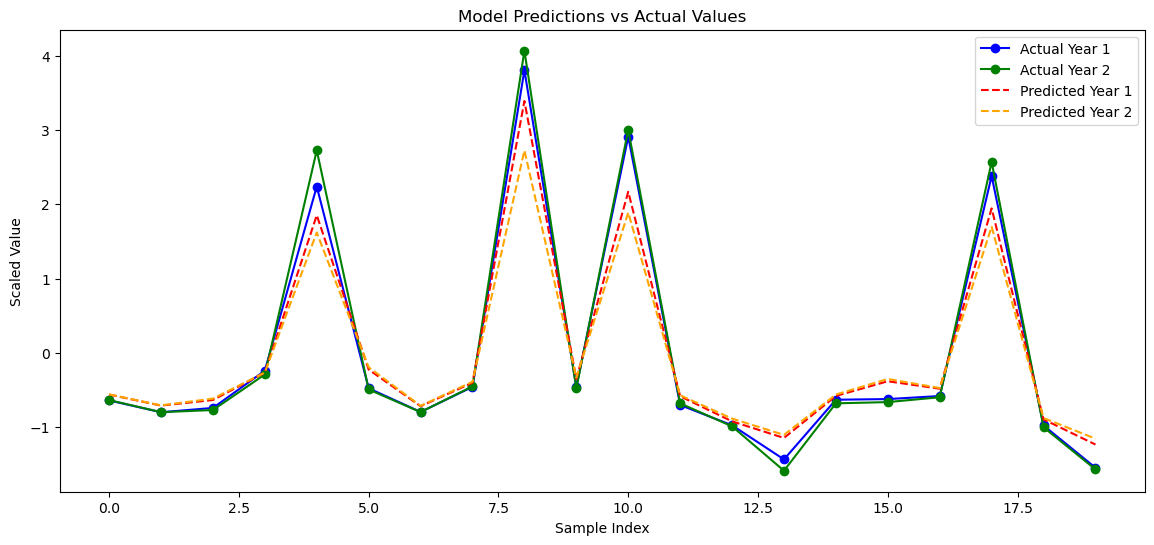

In [41]:

# Plotting
plt.figure(figsize=(14, 6))

# Plot the actual values
plt.plot(y_test[0:20:, 0], label='Actual Year 1', color='blue', marker='o')
plt.plot(y_test[0:20:, 1], label='Actual Year 2', color='green', marker='o')

# Plot the predicted values
plt.plot(y_pred[0:20:, 0], label='Predicted Year 1', color='red', linestyle='--')
plt.plot(y_pred[0:20:, 1], label='Predicted Year 2', color='orange', linestyle='--')

plt.title('Model Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

Now un-scale the predictions and plot against actuals

In [42]:
pred_df = pd.DataFrame(y_pred)
pred_df = pred_df.T
pred_df.index = list(test_df.tail(pred_length).index)
pred_df.columns = test_df.columns
for name in pred_df.columns:
    pred_df[name] = scalers[name].inverse_transform(pred_df[name].values.reshape(-1, 1))
pred_df

name_g,Mildred_F,Janice_F,Matthew_M,Spencer_M,Asa_M,Paris_M,Jim_M,Cody_M,Milo_M,Mable_F,...,Luana_F,Vidal_M,Silvia_F,Genoveva_F,Samantha_F,Silverio_M,Garth_M,Bennie_M,Millie_F,Drew_M
2021,202.433319,552.404907,9073.026367,1014.732483,519.999634,79.155983,161.435257,1350.551025,2631.975586,69.224998,...,91.944481,33.610569,162.449951,13.093304,3081.870117,11.739898,22.781708,66.471779,1409.252441,513.169983
2022,204.978729,568.784058,9355.503906,1017.451111,477.938141,81.097443,169.844315,1416.025635,2184.128418,72.243759,...,91.696869,33.349674,163.676849,13.182196,3220.028564,11.470960,26.644592,77.606728,1247.949219,524.329956


In [43]:
actual_df = df3[list(pred_df.columns)]
actual_df.head()

name_g,Mildred_F,Janice_F,Matthew_M,Spencer_M,Asa_M,Paris_M,Jim_M,Cody_M,Milo_M,Mable_F,...,Luana_F,Vidal_M,Silvia_F,Genoveva_F,Samantha_F,Silverio_M,Garth_M,Bennie_M,Millie_F,Drew_M
year,,,,,,,,,,,,,,,,,,,,,
1937,4645,7768,606,180,65,19,2348,22,111,691,...,30,16,33,27,23,15,83,885,205,20
1938,4440,8710,607,206,60,31,2496,21,95,641,...,31,20,46,18,17,17,82,872,216,36
1939,4137,8780,622,260,50,26,2636,20,85,639,...,46,19,44,21,23,10,60,876,242,44
1940,3937,9318,664,260,53,18,2715,19,100,589,...,35,13,48,40,19,21,86,845,232,49
1941,3848,10062,727,291,60,17,2843,23,94,539,...,41,21,44,23,20,17,73,839,224,48


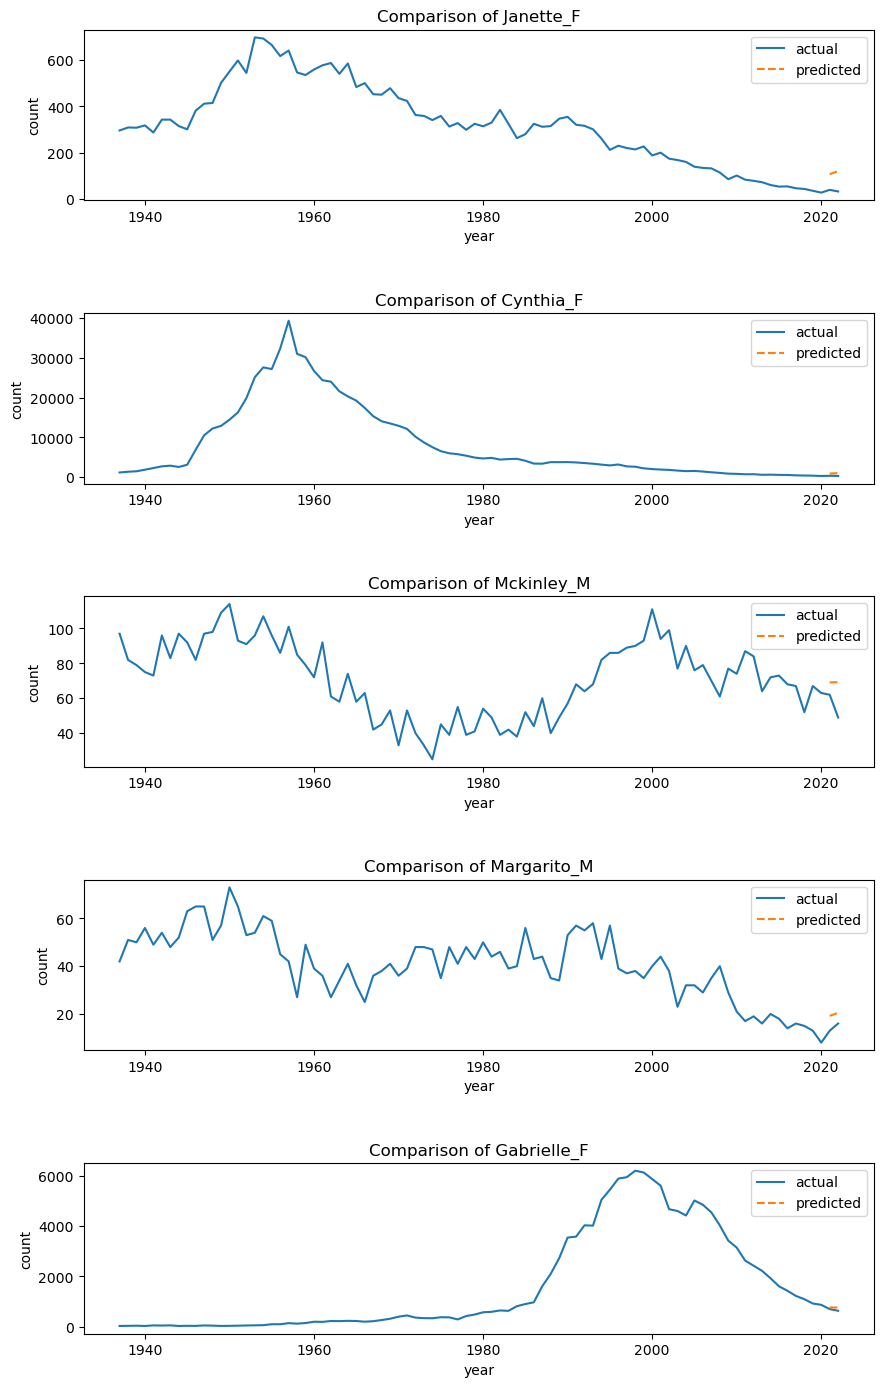

In [44]:
# plot some
num_to_plot = 5
np.random.seed(42)
columns_to_plot = np.random.choice(actual_df.columns, size=5, replace=False)
fig, axes = plt.subplots(nrows=num_to_plot, ncols=1, figsize=(10, 15))
fig.tight_layout(pad=6.0)
for i, col in enumerate(columns_to_plot):
    axes[i].plot(actual_df.index, actual_df[col], label='actual', linestyle='-') # , marker='o'
    axes[i].plot(pred_df.index, pred_df[col], label='predicted', linestyle='--') # , marker='x'
    
    axes[i].set_title(f'Comparison of {col}')
    axes[i].set_xlabel('year')
    axes[i].set_ylabel('count')
    axes[i].legend()

plt.show()


## re-plot, showing only recent years

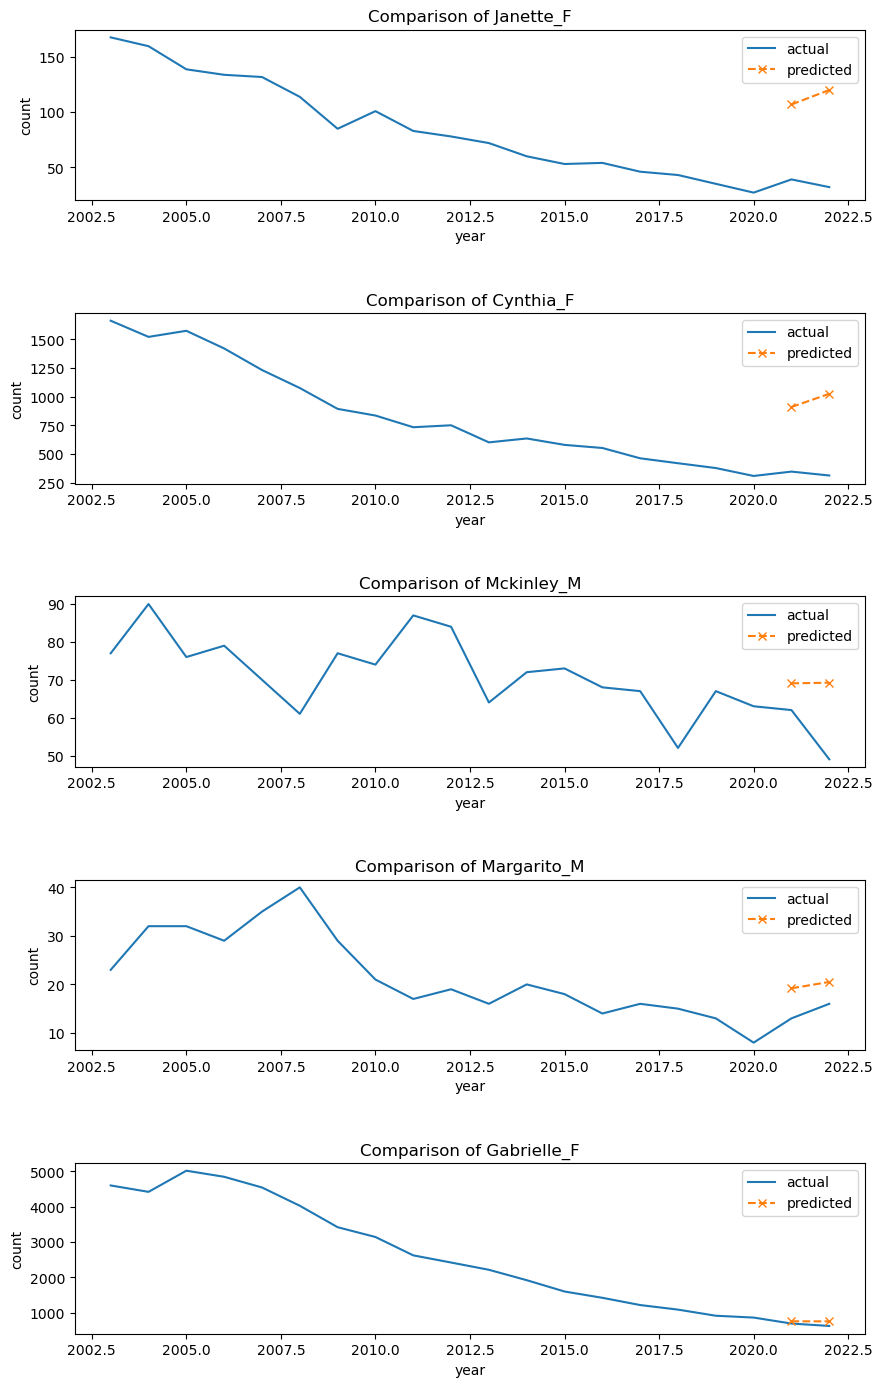

In [45]:
num_years_to_show = 20
fig, axes = plt.subplots(nrows=num_to_plot, ncols=1, figsize=(10, 15))
fig.tight_layout(pad=6.0)
for i, col in enumerate(columns_to_plot):
    axes[i].plot(actual_df.index[-num_years_to_show:], actual_df[col].tail(num_years_to_show), label='actual', linestyle='-')
    axes[i].plot(pred_df.index, pred_df[col], label='predicted', marker='x', linestyle='--')
    
    axes[i].set_title(f'Comparison of {col}')
    axes[i].set_xlabel('year')
    axes[i].set_ylabel('count')
    axes[i].legend()

plt.show()

## predictions vs. simply using previous value
* calc mean absolute error for year1 for predictions
* calc mean absolute error for year2 for predictions
* calc mean absolute error for year1 if i just guessed the 1 yr prev count
* calc mean absolute error for year2 if i just guessed the 2 yr prev count

In [46]:
pred_df.head()

name_g,Mildred_F,Janice_F,Matthew_M,Spencer_M,Asa_M,Paris_M,Jim_M,Cody_M,Milo_M,Mable_F,...,Luana_F,Vidal_M,Silvia_F,Genoveva_F,Samantha_F,Silverio_M,Garth_M,Bennie_M,Millie_F,Drew_M
2021,202.433319,552.404907,9073.026367,1014.732483,519.999634,79.155983,161.435257,1350.551025,2631.975586,69.224998,...,91.944481,33.610569,162.449951,13.093304,3081.870117,11.739898,22.781708,66.471779,1409.252441,513.169983
2022,204.978729,568.784058,9355.503906,1017.451111,477.938141,81.097443,169.844315,1416.025635,2184.128418,72.243759,...,91.696869,33.349674,163.676849,13.182196,3220.028564,11.470960,26.644592,77.606728,1247.949219,524.329956


In [47]:
actual_df.tail()

name_g,Mildred_F,Janice_F,Matthew_M,Spencer_M,Asa_M,Paris_M,Jim_M,Cody_M,Milo_M,Mable_F,...,Luana_F,Vidal_M,Silvia_F,Genoveva_F,Samantha_F,Silverio_M,Garth_M,Bennie_M,Millie_F,Drew_M
year,,,,,,,,,,,,,,,,,,,,,
2018,93,154,9995,1112,564,78,39,1252,2197,38,...,90,37,160,6,3918,9,15,38,1096,630
2019,77,141,9254,1037,565,74,39,1209,2439,37,...,95,37,182,7,3367,15,16,43,1316,552
2020,96,97,8120,1045,573,68,40,1129,2766,45,...,95,26,157,12,2952,12,20,53,1503,536
2021,102,85,7452,1048,590,63,37,1072,2910,49,...,110,36,164,10,2591,11,11,48,1692,576
2022,108,89,7025,985,678,62,34,1106,3087,45,...,105,49,163,8,2586,16,21,58,2182,564


In [48]:
pred_df

name_g,Mildred_F,Janice_F,Matthew_M,Spencer_M,Asa_M,Paris_M,Jim_M,Cody_M,Milo_M,Mable_F,...,Luana_F,Vidal_M,Silvia_F,Genoveva_F,Samantha_F,Silverio_M,Garth_M,Bennie_M,Millie_F,Drew_M
2021,202.433319,552.404907,9073.026367,1014.732483,519.999634,79.155983,161.435257,1350.551025,2631.975586,69.224998,...,91.944481,33.610569,162.449951,13.093304,3081.870117,11.739898,22.781708,66.471779,1409.252441,513.169983
2022,204.978729,568.784058,9355.503906,1017.451111,477.938141,81.097443,169.844315,1416.025635,2184.128418,72.243759,...,91.696869,33.349674,163.676849,13.182196,3220.028564,11.470960,26.644592,77.606728,1247.949219,524.329956


In [49]:
pred = pred_df.melt(ignore_index=False).reset_index()
pred.rename(columns={"index": "year"}, inplace=True)
pred.head()

,year,name_g,value
0,2021,Mildred_F,202.433319
1,2022,Mildred_F,204.978729
2,2021,Janice_F,552.404907
3,2022,Janice_F,568.784058
4,2021,Matthew_M,9073.026367


In [50]:
act = actual_df.tail(pred_length).melt(ignore_index=False).reset_index()
act.rename(columns={"index": "year"}, inplace=True)
act.head()

,year,name_g,value
0,2021,Mildred_F,102
1,2022,Mildred_F,108
2,2021,Janice_F,85
3,2022,Janice_F,89
4,2021,Matthew_M,7452


In [51]:
guess = actual_df.tail(pred_length+1).iloc[:1]
g21 = guess.copy()
g21.index = [2021]
g22 = guess.copy()
g22.index = [2022]
guess = pd.concat([g21, g22]).melt(ignore_index=False).reset_index()
guess.rename(columns={"index": "year"}, inplace=True)
guess.head()

,year,name_g,value
0,2021,Mildred_F,96
1,2022,Mildred_F,96
2,2021,Janice_F,97
3,2022,Janice_F,97
4,2021,Matthew_M,8120


In [52]:
# get abs of differences
merge1 = pd.merge(act, guess, on=['name_g', 'year'], how='inner', suffixes=('_actual', '_guess'))
merge2 = pd.merge(merge1, pred, on=['name_g', 'year'], how='inner')
merge2.rename(columns={"value": "pred", "value_actual": "actual", "value_guess": "guess"}, inplace=True)
merge2['guess_abs'] = abs(merge2['actual']-merge2['guess'])
merge2['pred_abs'] = abs(merge2['actual']-merge2['pred'])
merge2.head()


,year,name_g,actual,guess,pred,guess_abs,pred_abs
0,2021,Mildred_F,102,96,202.433319,6,100.433319
1,2022,Mildred_F,108,96,204.978729,12,96.978729
2,2021,Janice_F,85,97,552.404907,12,467.404907
3,2022,Janice_F,89,97,568.784058,8,479.784058
4,2021,Matthew_M,7452,8120,9073.026367,668,1621.026367


the followinbg are for both years combined

In [53]:
print(merge2['guess_abs'].sum()) # 58,574

58574


In [54]:
print(merge2['pred_abs'].sum()) 
# rount 1: 129,626.0...
# round 2: 175,454

175454.60696792603
